In [1]:
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [2]:
tickers = [
    "VTI", "VWO", "VEA", "BND", "NVDA", "TSLA", "AAPL", "GOOGL",
    "LMT", "RMBS", "PLTR", "MSFT", "PEP", "AVGO", "SOFI", "OKLO", "QSI"
]

df = yf.download(tickers, period="1y")["Close"]
df.head()

/var/folders/xm/pjfr6m5d7b3bfhc_bfrghpwh0000gn/T/ipykernel_19238/4033625588.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, period="1y")["Close"]
[*********************100%***********************]  17 of 17 completed


Ticker,AAPL,AVGO,BND,GOOGL,LMT,MSFT,NVDA,OKLO,PEP,PLTR,QSI,RMBS,SOFI,TSLA,VEA,VTI,VWO
Date,,,,,,,,,,,,,,,,,
2024-10-23,229.691010,171.824783,70.431030,162.065292,555.474915,421.436066,139.519989,18.299999,166.513046,42.590000,0.792,41.400002,10.42,213.649994,48.890854,281.505127,45.602982
2024-10-24,229.501877,169.685760,70.546516,162.005554,548.773499,421.565094,140.369751,18.059999,165.752441,43.560001,0.776,42.040001,10.93,260.480011,49.065151,282.255737,45.554604
2024-10-25,230.338013,171.319717,70.402176,164.544357,546.906006,424.959595,141.499420,19.110001,165.396210,44.860001,0.745,43.500000,10.99,269.190002,48.910221,281.989075,45.515896
2024-10-28,232.318771,170.349258,70.315559,165.988007,539.980713,423.411224,140.479736,24.500000,163.518784,44.970001,0.770,44.799999,11.19,262.510010,49.268501,283.134644,45.661037
2024-10-29,232.587524,177.499130,70.373291,168.934982,531.839783,428.731293,141.209503,24.840000,161.265884,44.930000,0.771,51.000000,10.47,259.519989,49.103889,283.509918,45.486866


In [3]:
returns = np.log(df / df.shift(1)).dropna()

# Asset-level mean and covariance
mu = returns.mean().values
cov = returns.cov().values

# Simulation parameters
dt = 1/252         # daily timestep
n_assets = len(tickers)
n_steps = 200      # forecast horizon in days
n_sims = 10000     # Monte Carlo paths
S0 = df.iloc[-1].values  # last observed prices

# Cholesky decomposition for correlated random shocks
L = np.linalg.cholesky(cov)

In [4]:
output = np.zeros((n_sims, n_steps, n_assets))  # simulated prices

for i in range(n_sims):
    S = S0.copy()
    for t in range(n_steps):
        Z = np.random.normal(size=n_assets)
        vol = np.sqrt(np.diag(cov))  # vector of std devs
        correlated_Z = np.dot(L, Z)  # correlated normals with unit variance
        S = S * np.exp((mu - 0.5 * vol**2) * dt + (correlated_Z.T * vol).T * np.sqrt(dt))
        output[i, t, :] = S

# Compute asset-level returns over the horizon
sim_asset_returns = output[:, -1, :] / output[:, 0, :] - 1
print("sim_asset_returns shape:", sim_asset_returns.shape)


sim_asset_returns shape: (10000, 17)


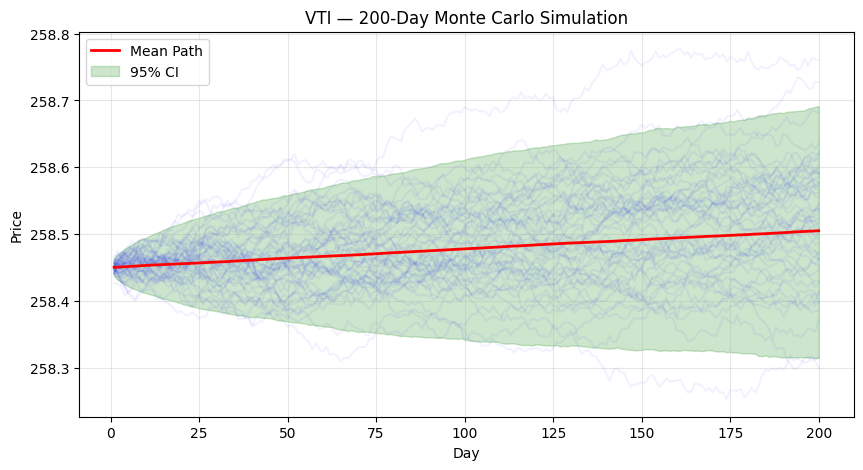

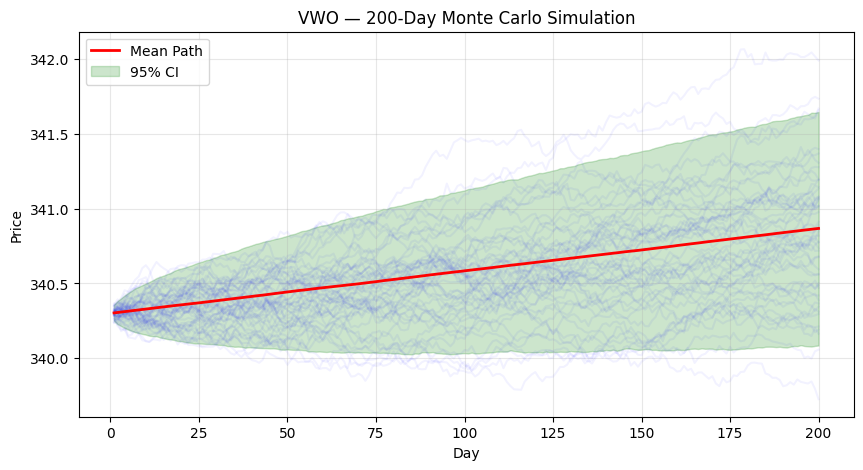

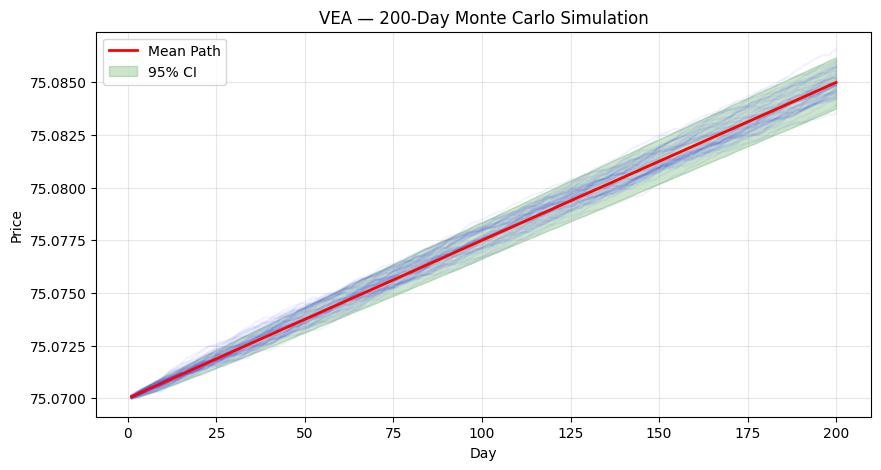

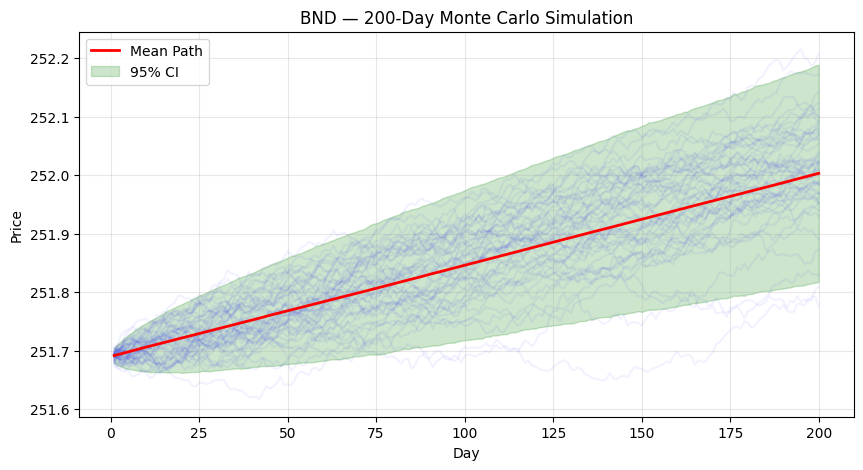

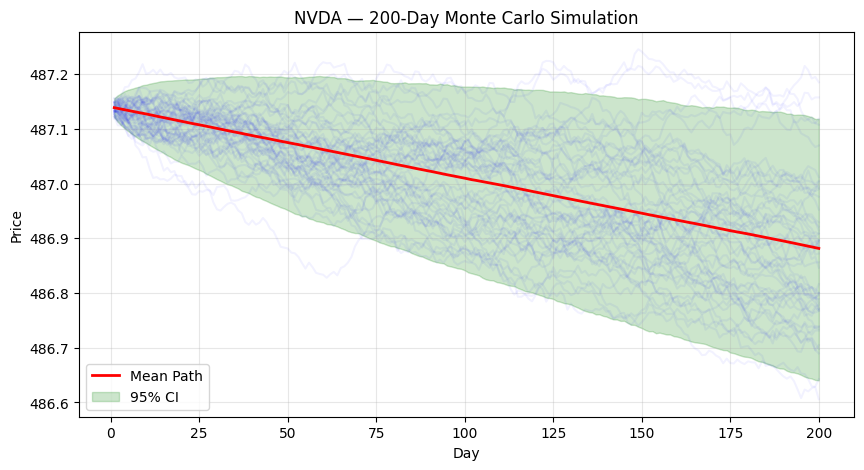

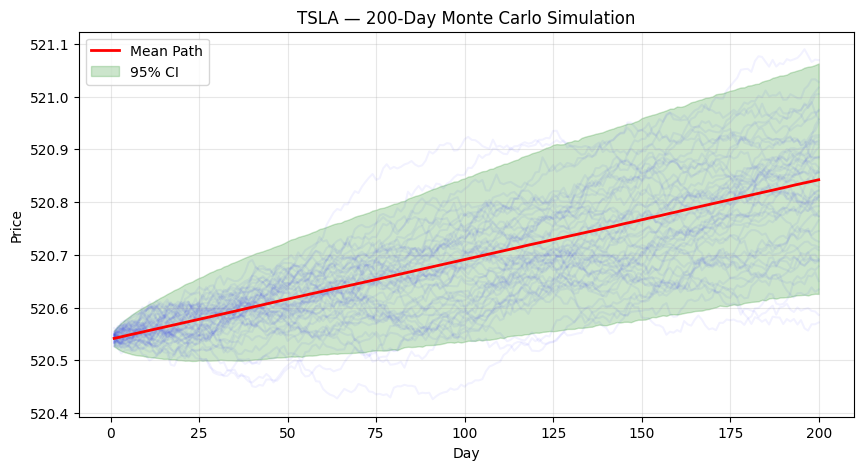

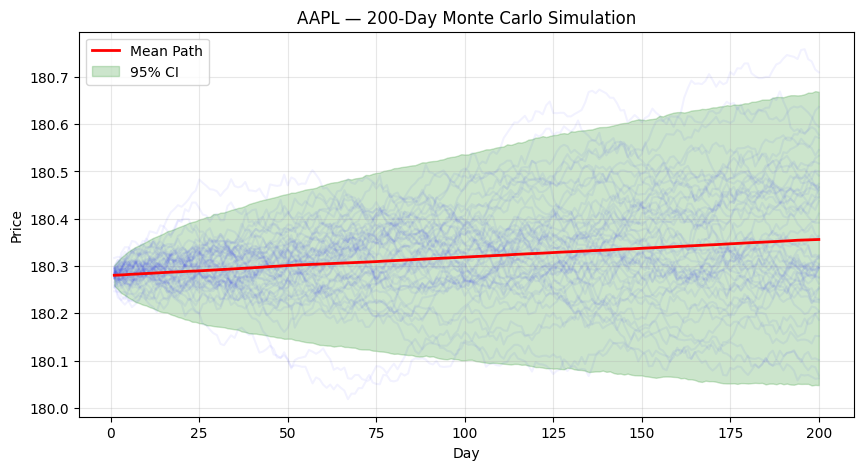

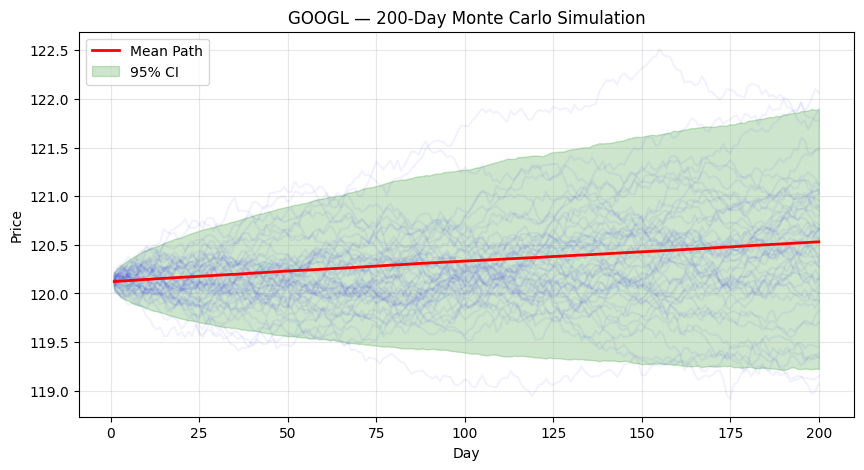

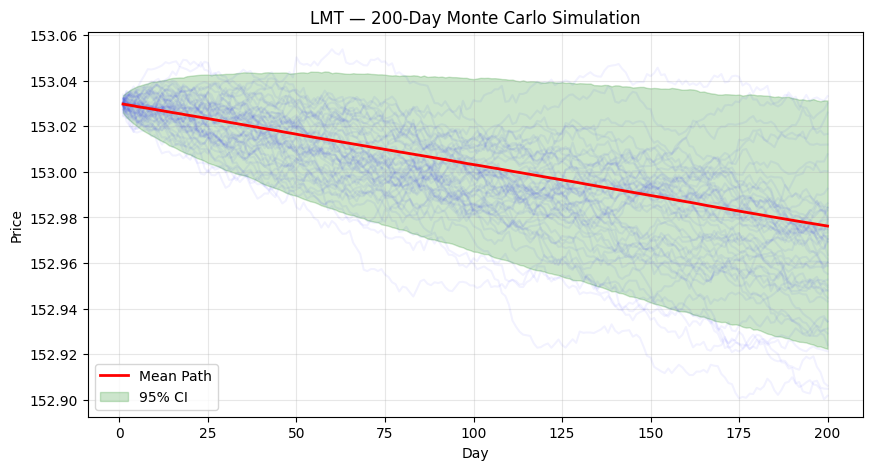

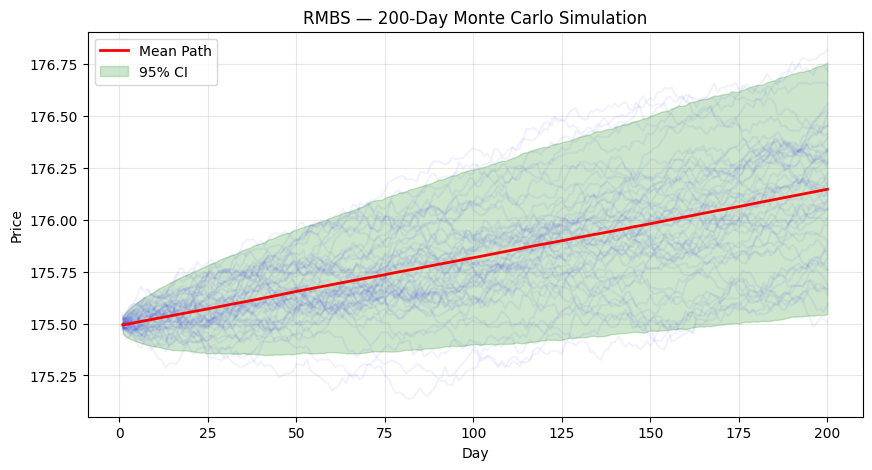

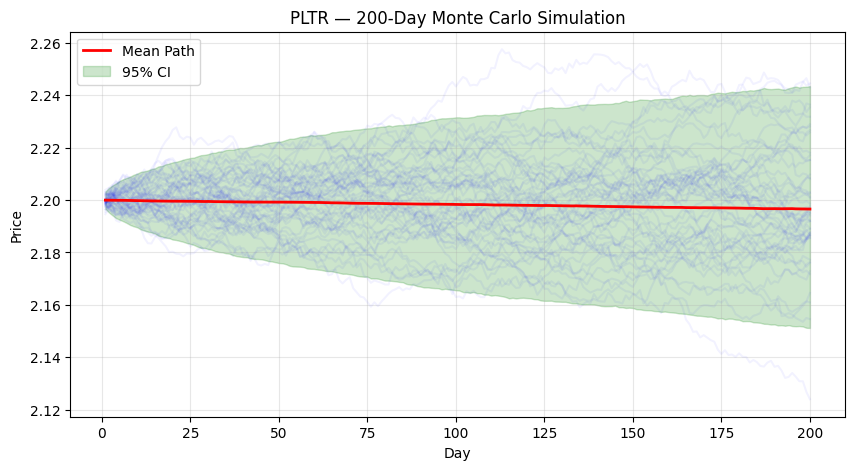

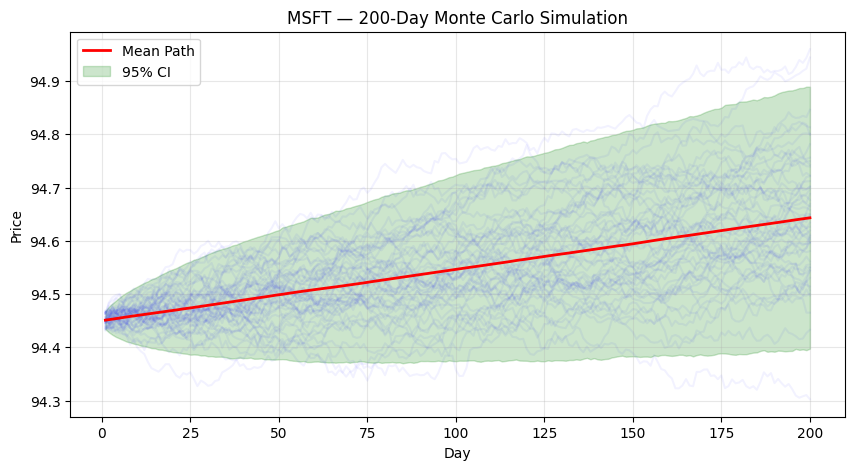

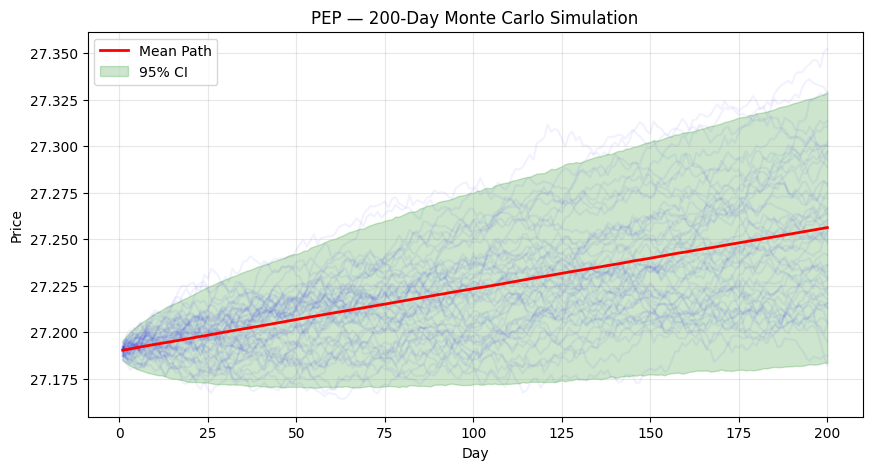

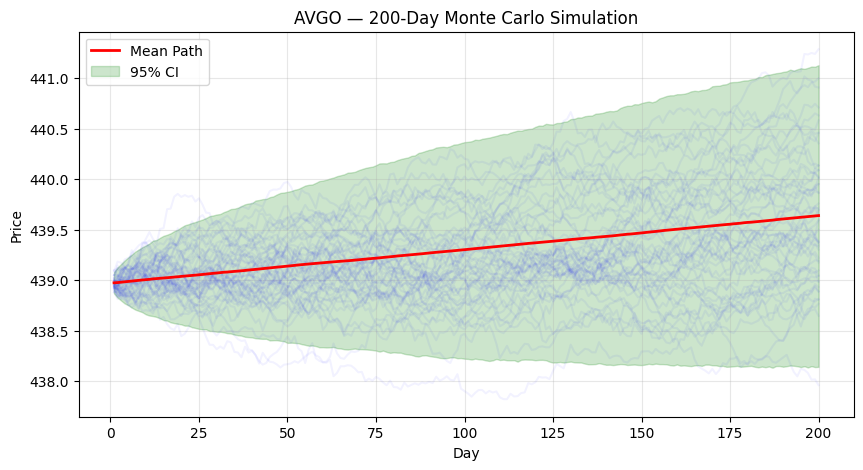

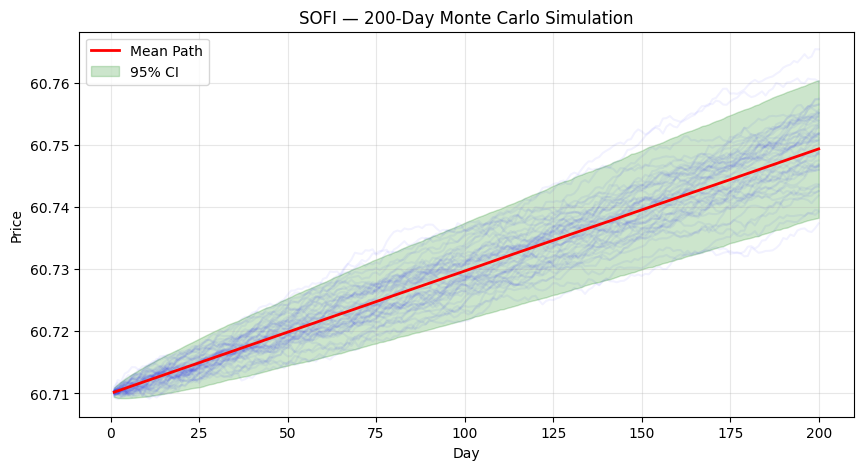

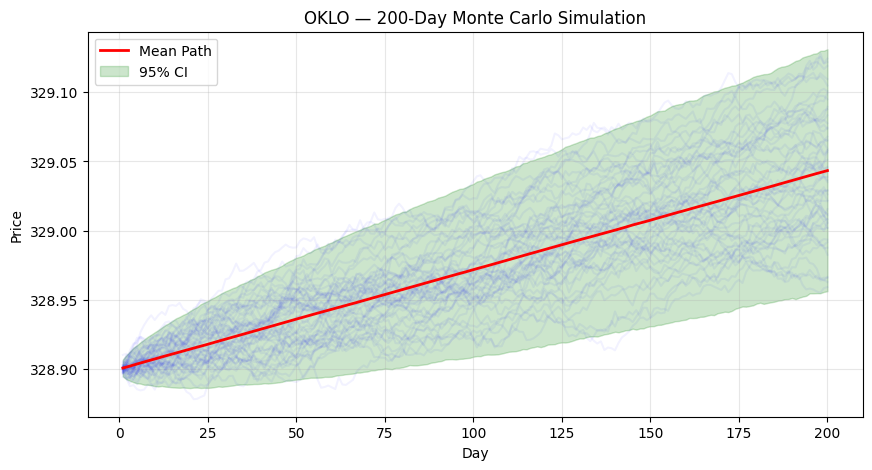

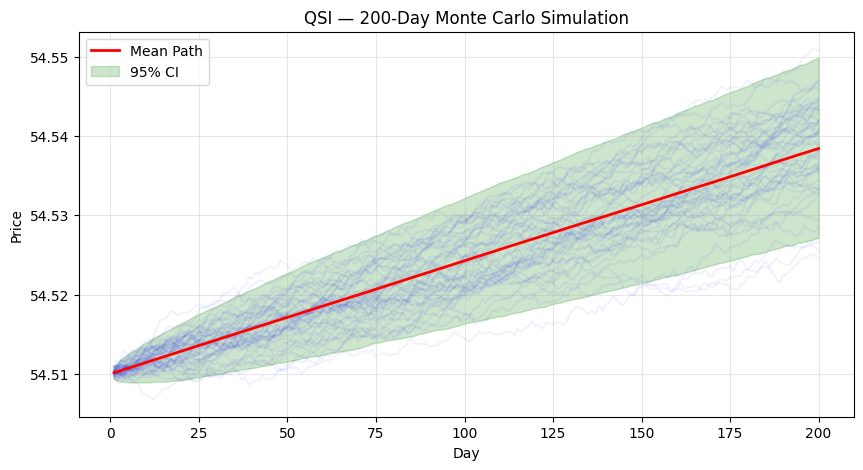

In [5]:
time = np.arange(1, n_steps + 1)

for idx, ticker in enumerate(tickers):
    plt.figure(figsize=(10, 5))

    # Plot 50 random sample paths for clarity
    for path in np.random.choice(np.arange(n_sims), size=50, replace=False):
        plt.plot(time, output[path, :, idx], color='blue', alpha=0.05)

    # Plot mean path
    mean_path = output[:, :, idx].mean(axis=0)
    plt.plot(time, mean_path, color='red', linewidth=2, label='Mean Path')

    # Plot 95% confidence interval
    p_lower = np.percentile(output[:, :, idx], 2.5, axis=0)
    p_upper = np.percentile(output[:, :, idx], 97.5, axis=0)
    plt.fill_between(time, p_lower, p_upper, color='green', alpha=0.2, label='95% CI')

    # Labels and grid
    plt.title(f"{ticker} — 200-Day Monte Carlo Simulation")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [6]:
weights = np.random.rand(n_assets)
weights /= weights.sum()  # normalize to sum=1

portfolio_values = np.sum(output * weights, axis=2)
final_returns = portfolio_values[:, -1] / portfolio_values[:, 0] - 1
alpha = 5
rf = 0.0355/252

VaR_95 = np.percentile(final_returns, 5)
CVaR_5 = final_returns[final_returns <= VaR_95].mean()
sharpe = (final_returns.mean() - rf) / final_returns.std()
print(f"Portfolio Sharpe Ratio: {sharpe:.2f}")
print("Random portfolio 5% VaR:", VaR_95)
print("Random portfolio 5% CVaR:", CVaR_5)

Portfolio Sharpe Ratio: 1.26
Random portfolio 5% VaR: -9.976567228536234e-05
Random portfolio 5% CVaR: -0.0003507105665807999


In [10]:
def portfolio_Cvar(weights, returns, alpha=5):
    """
    Compute portfolio VaR (5%) for a given set of weights.
    Returns negative VaR since we minimize for optimization.
    """
    portfolio_returns = returns @ weights
    var = np.percentile(portfolio_returns, alpha)
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    return -cvar

# Constraints: weights sum to 1, weights >= 0
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(0, 1) for _ in range(n_assets)]

initial_weights = np.ones(n_assets) / n_assets
result = minimize(portfolio_Cvar, initial_weights, args=(sim_asset_returns,), bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Optimal weights (min CVaR):", optimal_weights)
print("Optimal portfolio CVaR:", round(-result.fun * 100, 4), "%")
print("Sum of weights:", optimal_weights.sum())
print("Weight range:", optimal_weights.min(), "-", optimal_weights.max())

Optimal weights (min CVaR): [1.31478826e-17 2.08166817e-17 6.51172303e-17 3.52031005e-01
 1.65103135e-17 6.72105142e-02 3.02574696e-17 0.00000000e+00
 1.16824744e-17 2.37897173e-01 0.00000000e+00 1.95036723e-03
 3.43978249e-02 3.68894628e-17 1.97317212e-01 4.90059382e-17
 1.09195904e-01]
Optimal portfolio CVaR: 0.0541 %
Sum of weights: 1.0
Weight range: 0.0 - 0.3520310053185741


Portfolio Sharpe Ratio: 2.80
Portfolio 5% VaR: 0.0007582752014425821
CVaR 5% (Monte Carlo): 0.05%
Portfolio Mean Return: 0.0016328422219335998
Portfolio Std Dev: 0.0005326168144108873


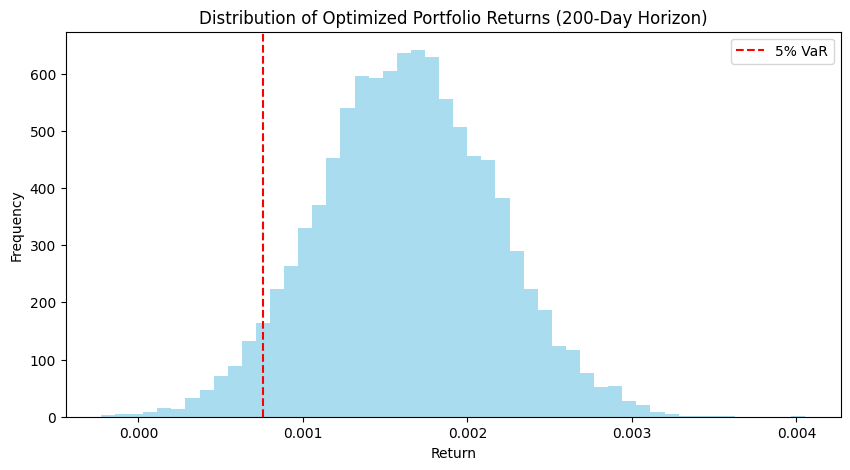

In [11]:
port_ret = sim_asset_returns @ optimal_weights
sharpe = (port_ret.mean()- rf) / port_ret.std()

print(f"Portfolio Sharpe Ratio: {sharpe:.2f}")
print("Portfolio 5% VaR:", np.percentile(port_ret, 5))
print(f"CVaR 5% (Monte Carlo): {port_ret[port_ret <=  np.percentile(port_ret, 5)].mean()*100:.2f}%")
print("Portfolio Mean Return:", port_ret.mean())
print("Portfolio Std Dev:", port_ret.std())

# Optional: visualize distribution of portfolio returns
plt.figure(figsize=(10,5))
plt.hist(port_ret, bins=50, alpha=0.7, color='skyblue')
plt.axvline(np.percentile(port_ret, 5), color='red', linestyle='--', label='5% VaR')
plt.title("Distribution of Optimized Portfolio Returns (200-Day Horizon)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()